## Seoul Bike Rental Prediction - AI-Pro - ITI

### Problem Statement:

In the competition, it's required to predict the bike count per hour to stabilize the supply of rental bikes all the time.

### Dataset Features Decription:

The dataset contains weather information (Temperature, Humidity, Windspeed, ..) also it includes the number of bikes rented per hour and date of rent information.

Features Information:


    ID - an ID for this instance
    Date - year-month-day
    Hour - Hour of he day
    Temperature - Temperature in Celsius
    Humidity - %
    Windspeed - m/s
    Visibility - 10m
    Dew point temperature - Celsius
    Solar radiation - MJ/m2
    Rainfall - mm
    Snowfall - cm
    Seasons - Winter, Spring, Summer, Autumn
    Holiday - Holiday/No holiday
    Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)
    y - Rented Bike count (Target), Count of bikes rented at each hour





### Setup Enviroment

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt  
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV,cross_val_score 
import os
import time
import datetime
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_log_error,mean_squared_error, make_scorer
plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")
pd.set_option('display.max_columns', 500)

In [2]:
dataset_path = '/kaggle/input/seoul-bike-rental-ai-pro-iti'
df = pd.read_csv(os.path.join(dataset_path, 'train.csv'))

<p> The dataset has no null values and no duplicate rows</p>

In [3]:
df.rename(columns={"ID": "ID",
                   "Date": "date",
                   'y':'count',
                   'Hour':'hour',
                   'Temperature(�C)':'temperature',
                  'Humidity(%)':'humidity',
                  'Wind speed (m/s)':'wind_speed',
                  'Visibility (10m)':'visibility',
                  'Dew point temperature(�C)':'dew_temperature',
                  'Solar Radiation (MJ/m2)':'solar_radiation',
                  'Rainfall(mm)':'rainfall',
                  'Snowfall (cm)':'snowfall',
                  'Seasons':'season',
                  'Holiday':'is_holiday',
                  'Functioning Day':'functional_day'},inplace=True)

In [4]:
df["date"] = pd.to_datetime(df["date"], dayfirst=True)
df['season']=df["season"].map({'Winter':1,'Spring':2,'Autumn':3,'Summer':4})

In [5]:
def cyclic_encode(data, column, max_value):
    data[column + '_sin'] = np.sin(2 * np.pi * data[column] / max_value)
    data[column + '_cos'] = np.cos(2 * np.pi * data[column] / max_value)
    data.drop(column,axis=1,inplace=True)
    return data

In [6]:
def break_fun(x):
    result=[]
    if np.quantile(x,0)> 0:
        result=[round(np.quantile(x,item),2) for item in np.linspace(0,1,5)]
    else:
        result=[round(np.quantile(x,item),2) for item in np.linspace(0,1,5)]
    return result

In [7]:
def hour_group(x):
    if x in range(0,7):
        return 0
    elif x in range(7,13):
        return 2
    elif x in range(13,19):
        return 4
    else:
        return 3

In [8]:
def month_group(x):
    if x in [1,1,12,3,11,4]:
        return 0
    else:
        return 1

In [9]:
import math
def date_features(data):
    # Date Features
    data['year'] = data.date.dt.year
    data['month'] = data.date.dt.month
#     data['hour_group']=data['hour'].map(lambda x:hour_group(x))
#     data['month_group']=data['month'].map(lambda x:month_group(x))
    data['day'] = data.date.dt.day
    data['dayofyear'] = data.date.dt.dayofyear
    data['dayofweek'] = data.date.dt.dayofweek
    data['day_name']=data.date.dt.day_name()
    data['label_day_night']=data['hour'].apply(lambda x : 0 if (x >20 or x<5) else 1)
    data['weekofyear'] = data.date.dt.weekofyear
    data.drop(['date','day_name'], axis=1, inplace=True)
    return data

In [10]:
df.head()

,ID,date,count,hour,temperature,humidity,wind_speed,visibility,dew_temperature,solar_radiation,rainfall,snowfall,season,is_holiday,functional_day
0,0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,1,No Holiday,Yes
1,1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,1,No Holiday,Yes
2,2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,1,No Holiday,Yes
3,3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,1,No Holiday,Yes
4,4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,1,No Holiday,Yes


In [11]:
hourly_temp = list(range(1,13))
cut_bins1 = [-18, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40]
df['hourly_temp'] = pd.cut(df['temperature'], bins=cut_bins1, labels=hourly_temp)
cols_reg = ['hourly_temp']
df[cols_reg] = df[cols_reg].apply(pd.to_numeric, errors='coerce', axis=1)

In [12]:
cut_bins1d = [-30, -25,-20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30]
df['hourly_tempd'] = pd.cut(df['dew_temperature'], bins=cut_bins1d, labels=hourly_temp)
df[['hourly_tempd']] = df[['hourly_tempd']].apply(pd.to_numeric, errors='coerce', axis=1)

In [13]:
df=date_features(df)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  del sys.path[0]


In [14]:
df['is_holiday'] = [0 if item == 'No Holiday' else 1 for item in df['is_holiday']]
df['functional_day'] = [0 if item == 'No' else 1 for item in df['functional_day']]
df["work_day"] = [0 if int(x)>4 else 1 for x in df["day"]]

In [15]:
from sklearn.cluster import KMeans
cx=df[['temperature','humidity','wind_speed','visibility','solar_radiation','rainfall','snowfall']]
kmeans = KMeans(n_clusters=4, random_state=0).fit(cx)
kmeans.labels_
cluster_pred=kmeans.predict(df[['temperature','humidity','wind_speed','visibility','solar_radiation','rainfall','snowfall']])
kmeans.cluster_centers_,cluster_pred
df['weath']=cluster_pred

In [16]:
shift_roll_cols=['temperature', 'humidity', 'wind_speed', 'visibility','solar_radiation', 'rainfall','hour']

In [17]:
def add_rolls_time_series(df):
    for col in shift_roll_cols:
            for i in range(1,3):
                shifted = df[col].shift(i)
                window = shifted.rolling(window=1 if col not in ('rainfall', 'snowfall') else 2)
                means = window.mean()
                df[col+'_roll_'+str(i)]=means
                df[col+'_roll_'+str(i)].fillna(means)
    return df

In [18]:
def add_shifts_time_series(df):
    for col in shift_roll_cols:
        for i in range(1,3):
            shifted = df[col].shift(i)
            df[col+'_shift_'+str(i)]=shifted
            df[col+'_shift_'+str(i)].fillna(shifted)
    return df

In [19]:
df=add_rolls_time_series(df)

In [20]:
df=add_shifts_time_series(df)

In [21]:
df=cyclic_encode(df,'month',12)
df=cyclic_encode(df,'hour',23)

In [22]:
df=df.fillna(0)

In [23]:
df['count_log'] = np.log1p(df['count'])

In [24]:
df.sample(5)

,ID,count,temperature,humidity,wind_speed,visibility,dew_temperature,solar_radiation,rainfall,snowfall,season,is_holiday,functional_day,hourly_temp,hourly_tempd,year,day,dayofyear,dayofweek,label_day_night,weekofyear,work_day,weath,temperature_roll_1,temperature_roll_2,humidity_roll_1,humidity_roll_2,wind_speed_roll_1,wind_speed_roll_2,visibility_roll_1,visibility_roll_2,solar_radiation_roll_1,solar_radiation_roll_2,rainfall_roll_1,rainfall_roll_2,hour_roll_1,hour_roll_2,temperature_shift_1,temperature_shift_2,humidity_shift_1,humidity_shift_2,wind_speed_shift_1,wind_speed_shift_2,visibility_shift_1,visibility_shift_2,solar_radiation_shift_1,solar_radiation_shift_2,rainfall_shift_1,rainfall_shift_2,hour_shift_1,hour_shift_2,month_sin,month_cos,hour_sin,hour_cos,count_log
932,932,342,1.2,51,0.6,1544,-7.8,0.00,0.0,0.0,1,0,1,5,5,2018,19,19,4,1,3,0,2,2.0,2.9,48.0,45.0,1.8,1.6,1519.0,1629.0,0.00,0.04,0.0,0.0,19.0,18.0,2.0,2.9,48.0,45.0,1.8,1.6,1519.0,1629.0,0.00,0.04,0.0,0.0,19.0,18.0,0.500000,8.660254e-01,-0.730836,0.682553,5.837730
1571,1571,475,6.3,41,1.3,1519,-6.0,2.12,0.0,0.0,2,0,1,6,5,2018,6,65,1,1,10,0,2,3.7,1.2,51.0,62.0,1.3,0.8,1596.0,1338.0,1.56,0.85,0.0,0.0,10.0,9.0,3.7,1.2,51.0,62.0,1.3,0.8,1596.0,1338.0,1.56,0.85,0.0,0.0,10.0,9.0,1.000000,6.123234e-17,0.136167,-0.990686,6.165418
1221,1221,119,-5.6,69,2.2,1984,-10.3,0.00,0.0,0.0,1,0,1,3,4,2018,11,42,6,0,6,0,0,-5.7,-5.2,67.0,66.0,2.6,3.1,2000.0,2000.0,0.00,0.00,0.0,0.0,20.0,19.0,-5.7,-5.2,67.0,66.0,2.6,3.1,2000.0,2000.0,0.00,0.00,0.0,0.0,20.0,19.0,0.866025,5.000000e-01,-0.519584,0.854419,4.787492
759,759,177,-6.5,26,2.4,1987,-22.8,0.96,0.0,0.0,1,0,1,3,2,2018,12,12,4,1,2,0,0,-7.2,-8.2,28.0,29.0,2.3,2.0,1990.0,1920.0,1.14,1.19,0.0,0.0,14.0,13.0,-7.2,-8.2,28.0,29.0,2.3,2.0,1990.0,1920.0,1.14,1.19,0.0,0.0,14.0,13.0,0.500000,8.660254e-01,-0.816970,-0.576680,5.181784
1832,1832,384,1.3,57,1.0,1974,-6.2,0.32,0.0,0.0,2,0,1,5,5,2018,17,76,5,1,11,0,0,0.5,0.8,64.0,63.0,0.8,1.0,2000.0,2000.0,0.01,0.00,0.0,0.0,7.0,6.0,0.5,0.8,64.0,63.0,0.8,1.0,2000.0,2000.0,0.01,0.00,0.0,0.0,7.0,6.0,1.000000,6.123234e-17,0.816970,-0.576680,5.953243


In [25]:
def rmsle(y, y_pred):
    y = np.expm1(y)
    y_pred=y_pred.clip(min=0,max=10)
    y_pred = np.expm1(y_pred)
    return np.sqrt(mean_squared_log_error(y, y_pred))

In [26]:
train = df[df['day']<=16]
test = df[df['day']>16]
drop_cols=['ID','count','count_log','day', 'dew_temperature','hourly_tempd','hourly_temp','year','work_day','weath','label_day_night','wind_speed_shift_1']
X_train = train.drop(drop_cols,axis=1)
y_train = train['count_log']
X_test = test.drop(drop_cols,axis=1)
y_test = test['count_log']

In [27]:
cols=X_train.columns
cols

Index(['temperature', 'humidity', 'wind_speed', 'visibility',
       'solar_radiation', 'rainfall', 'snowfall', 'season', 'is_holiday',
       'functional_day', 'dayofyear', 'dayofweek', 'weekofyear',
       'temperature_roll_1', 'temperature_roll_2', 'humidity_roll_1',
       'humidity_roll_2', 'wind_speed_roll_1', 'wind_speed_roll_2',
       'visibility_roll_1', 'visibility_roll_2', 'solar_radiation_roll_1',
       'solar_radiation_roll_2', 'rainfall_roll_1', 'rainfall_roll_2',
       'hour_roll_1', 'hour_roll_2', 'temperature_shift_1',
       'temperature_shift_2', 'humidity_shift_1', 'humidity_shift_2',
       'wind_speed_shift_2', 'visibility_shift_1', 'visibility_shift_2',
       'solar_radiation_shift_1', 'solar_radiation_shift_2',
       'rainfall_shift_1', 'rainfall_shift_2', 'hour_shift_1', 'hour_shift_2',
       'month_sin', 'month_cos', 'hour_sin', 'hour_cos'],
      dtype='object')

In [28]:
from catboost import Pool, CatBoostRegressor


train_dataset = Pool(data=X_train,
                     label=y_train)

test_dataset = Pool(data=X_test,
                    label=y_test)

model = CatBoostRegressor(iterations=30000,
                          learning_rate=0.025,
                          depth=4,
                          loss_function='MAE',
                          random_seed = 42,
                          random_strength = 4 ,
                          l2_leaf_reg=0.2,
                          od_type='Iter',
                          metric_period = 5000,
                          od_wait=6000,
                          use_best_model=True)
model.fit(train_dataset,eval_set=test_dataset,use_best_model=True)
pred_1 = model.predict(X_train)
pred = model.predict(X_test) 

met1 = rmsle(y_train, pred_1)
print('RMSLE : ', met1) 

met2 = rmsle(y_test, pred)
print('RMSLE : ', met2) 

0:	learn: 1.1565995	test: 1.1120048	best: 1.1120048 (0)	total: 55.3ms	remaining: 27m 40s
5000:	learn: 0.1103710	test: 0.1728399	best: 0.1728399 (5000)	total: 14.3s	remaining: 1m 11s
10000:	learn: 0.0956515	test: 0.1704287	best: 0.1703241 (9628)	total: 28.3s	remaining: 56.6s
15000:	learn: 0.0876658	test: 0.1690309	best: 0.1690235 (14978)	total: 42.5s	remaining: 42.5s
20000:	learn: 0.0827765	test: 0.1681916	best: 0.1681875 (19923)	total: 56.7s	remaining: 28.3s
25000:	learn: 0.0792510	test: 0.1678037	best: 0.1678013 (24995)	total: 1m 10s	remaining: 14.1s
29999:	learn: 0.0764768	test: 0.1674766	best: 0.1674704 (29838)	total: 1m 24s	remaining: 0us

bestTest = 0.1674704338
bestIteration = 29838

Shrink model to first 29839 iterations.
RMSLE :  0.19848150157090275
RMSLE :  0.3183922734464548


              feature_names  feature_importance
20        visibility_roll_2            0.195199
19        visibility_roll_1            0.182946
31       wind_speed_shift_2            0.177743
34  solar_radiation_shift_1            0.176223
18        wind_speed_roll_2            0.173860
2                wind_speed            0.163675
29         humidity_shift_1            0.142734
32       visibility_shift_1            0.141817
33       visibility_shift_2            0.058173
6                  snowfall            0.031796


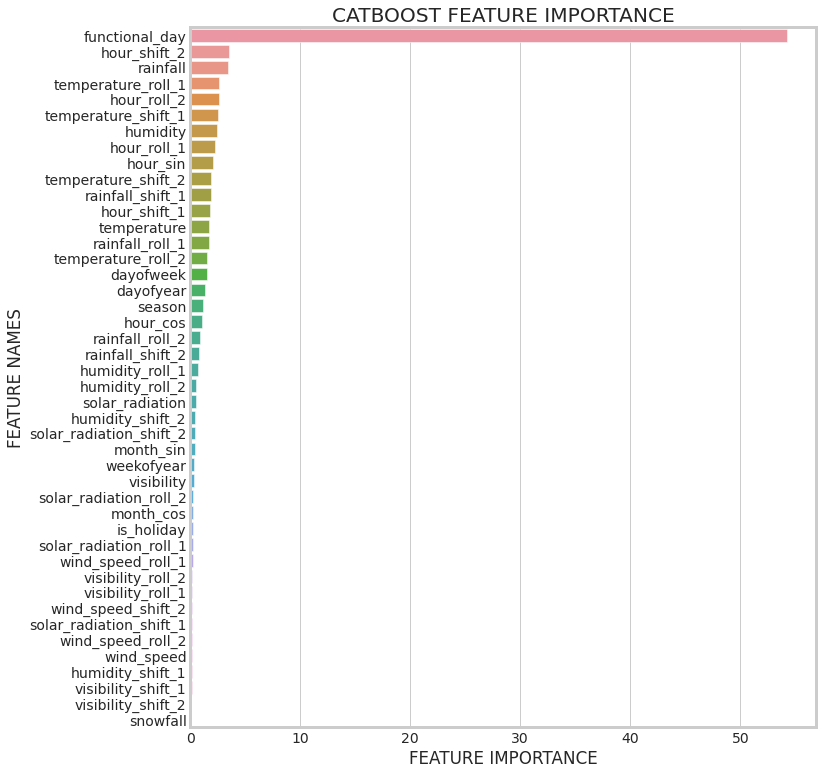

In [29]:

def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    print(fi_df.tail(10))
    #Define size of bar plot
    plt.figure(figsize=(10,12))
    #Plot Searborn bar chart
    
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(model.get_feature_importance(),X_train.columns,'CATBOOST')


In [30]:
test_df = pd.read_csv(os.path.join(dataset_path, 'test.csv'))

In [31]:
test_df.describe()

,ID,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,7259.500000,11.500000,13.035300,57.966000,1.727933,1366.005333,4.103667,0.562940,0.174733,0.130300
std,866.169729,6.923341,12.026752,21.330288,1.013826,643.374688,13.170840,0.866555,1.223086,0.592634
min,5760.000000,0.000000,-17.800000,0.000000,0.000000,33.000000,-30.600000,0.000000,0.000000,0.000000
25%,6509.750000,5.750000,3.900000,40.000000,0.900000,779.000000,-3.900000,0.000000,0.000000,0.000000
50%,7259.500000,11.500000,13.950000,58.000000,1.500000,1591.500000,4.900000,0.010000,0.000000,0.000000
75%,8009.250000,17.250000,22.900000,76.000000,2.400000,2000.000000,15.600000,0.910000,0.000000,0.000000
max,8759.000000,23.000000,38.000000,98.000000,6.900000,2000.000000,26.800000,3.520000,29.500000,8.800000


In [32]:
test_df.rename(columns={
                   "Date": "date",
                   'y':'count',
                   'Hour':'hour',
                   'Temperature(�C)':'temperature',
                  'Humidity(%)':'humidity',
                  'Wind speed (m/s)':'wind_speed',
                  'Visibility (10m)':'visibility',
                  'Dew point temperature(�C)':'dew_temperature',
                  'Solar Radiation (MJ/m2)':'solar_radiation',
                  'Rainfall(mm)':'rainfall',
                  'Snowfall (cm)':'snowfall',
                  'Seasons':'season',
                  'Holiday':'is_holiday',
                  'Functioning Day':'functional_day'},inplace=True)

In [33]:
test_df["date"] = pd.to_datetime(test_df["date"], dayfirst=True)
test_df=date_features(test_df)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  del sys.path[0]


In [34]:
cluster_test_pred=kmeans.predict(test_df[['temperature','humidity','wind_speed','visibility','solar_radiation','rainfall','snowfall']])
test_df['weath']=cluster_test_pred

In [35]:
test_df=add_rolls_time_series(test_df)

In [36]:
test_df=add_shifts_time_series(test_df)

In [37]:
test_df=test_df.fillna(0)

In [38]:
test_df['hourly_temp'] = pd.cut(test_df['temperature'], bins=cut_bins1, labels=hourly_temp)
test_df[cols_reg] = test_df[cols_reg].apply(pd.to_numeric, errors='coerce', axis=1)

In [39]:
cut_bins1d = [-30, -25,-20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30]
test_df['hourly_tempd'] = pd.cut(df['dew_temperature'], bins=cut_bins1d, labels=hourly_temp)
test_df[['hourly_tempd']] = test_df[['hourly_tempd']].apply(pd.to_numeric, errors='coerce', axis=1)

In [40]:
test_df['season']=test_df["season"].map({'Winter':1,'Spring':2,'Autumn':3,'Summer':4})
test_df['is_holiday'] = [0 if item == 'No Holiday' else 1 for item in test_df['is_holiday']]
test_df['functional_day'] = [0 if item == 'No' else 1 for item in test_df['functional_day']]
test_df["work_day"] = [0 if int(x)>4 else 1 for x in test_df["day"]]
test_df=cyclic_encode(test_df,'month',12)
test_df=cyclic_encode(test_df,'hour',23)

In [41]:
y_test_pred = model.predict(test_df[cols])
y_test_pred=y_test_pred.clip(min=0,max=10)
y_test_pred = np.expm1(y_test_pred)
test_df['y']=y_test_pred
test_df.loc[(test_df['functional_day']==0),'y'] = 0

In [42]:
submit_path='/kaggle/working/submission.csv'
test_df[['ID', 'y']].to_csv(submit_path, index=False)